<a href="https://colab.research.google.com/github/on-kulyashov/RQC-projects/blob/main/fermions_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

size = 4


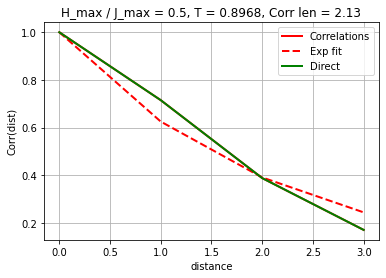

In [ ]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import expm, sinm, cosm
from scipy.integrate import quad
from sklearn.preprocessing import normalize
 
# np.set_printoptions(precision=2)
 
 
# with open('test_fermi') as f:
#     h = list(map(float, (f.readline()).split(" ")))
#     j = list(map(float, (f.readline()).split(" ")))
#     T = float(f.readline())
# n = len(h)
 
n = 4
hmax = 0.5
T1, T2 = 0.5, 2  # 0.001, 0.033
seed = 53
np.random.seed(seed)
j = np.random.uniform(size=(n-1))
h = np.random.uniform(0, hmax, size=n)
T = np.random.uniform(T1,T2)
time = np.arange(0,1,0.1)
with open('test_fermi', "w") as f: # for first compilation change w to x
    f.write(str(h) + " \n " + str(j) + " \n " + str(T))
 
 
# long-distance limit
g = hmax # g = 1 - critical, g must be close to one 
a = 0.01 # goes to zero
J = 3 # goes to infinity
c = 2 * J * a
delta = 2 * J * (1 - g)
z = J**(-0.25)
 
# for trial
# j = np.full(n, J)
# h = g * j
 
def f_i(s):
    def integrand(y):
        return np.log(np.tanh((y**2 + s**2)**(0.5) / 2))
    return abs(s) * np.heaviside(s, 0.5) - (1 / np.pi) * quad(integrand, 0, float('inf'))[0]
 
 
def g_i(s):
    def integrand(y):
        def integrand_f(w):
            return y / (np.sinh(np.sqrt(y**2 + w**2))*np.sqrt(y**2 + w**2))
        a = 0
        if y <= 0:
            a = -1
        return (a  + (1 / np.pi) * quad(integrand_f, 0, float('inf'))[0])**2 / y
    return np.exp(quad(integrand, s, float('inf'))[0]) + np.log(s) / 4
 
 
def sigma_z_ld(x):
    return z * T**(0.25) * g_i(delta / T) * np.exp(-T*abs(x)*f_i(delta / T) / c)
 
 
# ising limit
 
def ising_correl(x):
    # for periodic border
    # lmin = 2 * np.sinh(J / T)
    # lpls = 2 * np.cosh(J / T)
    # z = lmin**n + lpls**n
    # return ((lmin**x) * (lpls**(n-x)) + (lpls**x) * (lmin**(n-x))) / z
    return np.tanh(J / T)**x
 
 
# direct solution
pauli = np.array([ [[0,1],[1,0]], [[0,-1j],[1j,0]], [[1,0],[0,-1]] ])
dbl_pauli = np.array([np.kron(a,a) for a in pauli])
 
# hamiltonian construction
def Hamiltonian(h, j):
    H = np.zeros(2**n)
    for i in range(n-1):
        H = H + j[i]*np.kron(np.kron(np.eye(2**i), dbl_pauli[2]), np.eye(2**(n-2-i)))
    for i in range(n):
        H = H + h[i]*np.kron(np.kron(np.eye(2**i), pauli[0]), np.eye(2**(n-1-i)))
    return np.real_if_close(H)
H = -Hamiltonian(h, j)
E, V = np.linalg.eig(H)
E = np.real_if_close(E)
V = np.real_if_close(V)
idx = np.argsort(E)
E = E[idx]
V = V[:,idx]

def initial_state_direct(hamilt, temperature):
    if temperature:
        dens_direct = expm(-H / T)
        dens_direct = dens_direct / np.trace(dens_direct)
        return dens_direct

def yn1(f, yn, xn, h):
    k1 = f(xn, yn)
    k2 = f(xn + h/2, yn + h*k1/2)
    k3 = f(xn + h/2, yn + h*k2/2)
    k4 = f(xn + h, yn + h*k3)
    return yn + h/6 * (k1 + 2*k2 + 2*k3 + k4)


def integrate(f, a, b, y_a, h):
    sol = [y_a]
    for i in range(int((b-a)//h) + 1):
        sol.append(yn1(f, sol[-1], a + i*h, h))
    return sol



# correlator construction
def sigma_z(i, j):
    if i - j:
        return np.real(np.kron(np.kron(np.kron(np.kron(np.eye(2**i), pauli[2]), np.eye(2**(j-i-1))), pauli[2]), np.eye(2**(n-j-1))))
    return np.real(np.kron(np.kron(np.eye(2**i), np.matmul(pauli[2], pauli[2])), np.eye(2**(n-i-1))))
 
def s_direct(i0, j0):
    i = min(i0, j0)
    j = max(i0, j0)
    dens_direct = initial_state_direct(hamilt, temperature)
    # thermal state
    return np.trace(np.matmul(dens_direct, sigma_z(i,j)))
    # ground state
    # return (np.matmul(np.transpose(V[:,0]), np.matmul(sigma_z(i,j), V[:,0])))
 
# Young's solution
 
def hamiltonian(h, j):
    print("size = {}".format(n))
    mid = np.zeros((n, n))
    up = np.zeros((n, n))
    dn = np.zeros((n, n))
    for i in range(n):
        mid[i][i] = float(h[i])
    for i in range(n-1):
        up[i][i+1] = float(j[i]) / 2 # divided by two
        dn[i+1][i] = float(j[i]) / 2 # divided by two
    a = (mid - up - dn)
    b = -(up - dn)
    return np.block([[a, b], [-b, -a]])


e, u = np.linalg.eigh(hamiltonian(h, j))
idx = np.argsort(e)[::-1]
e = e[idx]
e = np.concatenate((e[:n], e[-1:n-1:-1]))
u = u[:,idx]
u = np.concatenate((u[:,:n], u[:,-1:n-1:-1]), axis=1)
u1 = u[:,:n]
phi = np.transpose(u1[:n,:] + u1[n:,:])
psi = np.transpose(u1[:n,:] - u1[n:,:])
e_dens = np.diag(1 / (1 + np.exp(2 * e[:n] / T)))
# thermal state
g = -np.matmul(np.transpose(psi), np.matmul((np.eye(n) - 2*e_dens), phi))
# ground state
# g = -np.matmul(np.transpose(psi), phi)
 
def s(i0, j0):
    i = min(i0, j0)
    j = max(i0, j0)
    wick = g[i:j, (i+1):(j+1)]
    return np.linalg.det(wick)
 
 
def fit_func(x, l):
    return np.exp(-x/l)
 
start = 0
finish = n
correlations = np.array([s(start, x) for x in range(start, finish)])
corr_direct = np.real_if_close(np.array([s_direct(start, x) for x in range(start, finish)]))
norm = corr_direct[0]
corr_direct = corr_direct / norm
dist = np.arange(len(correlations))
popt, pcov = curve_fit(fit_func, dist, correlations)
plt.plot(dist, correlations, 'r-', linewidth=2.0)
plt.plot(dist, fit_func(dist, *popt), 'r--', linewidth=2.0)
# plt.plot(dist, ising_correl(dist), 'm-', linewidth=2.0)
# plt.plot(dist, sigma_z_ld(dist), 'b-', linewidth=2.0)
plt.plot(dist, corr_direct, 'g-', linewidth=2.0)
plt.xlabel("distance")
plt.ylabel("Corr(dist)")
plt.legend(["Correlations", "Exp fit", "Direct"])
plt.title("H_max / J_max = {}, T = {}, Corr len = {}".format(np.round(hmax,2), np.round(T,4), np.round(*popt,2)))
plt.grid()
plt.show()